<a href="https://colab.research.google.com/github/infiniteoverflow/Simple-RNN/blob/master/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch


# Defining the dataset

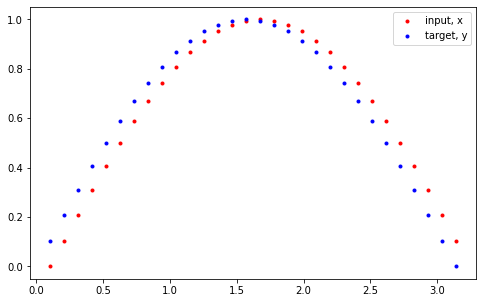

In [7]:
plt.figure(figsize=(8,5))

seq_length = 30

time_series = np.linspace(0,np.pi,num=seq_length+1)
data = np.sin(time_series)

data.resize((seq_length+1 , 1))

x = data[:-1]
y = data[1:]

plt.plot(time_series[1:], x, 'r.', label='input, x') # x
plt.plot(time_series[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')

plt.show()

---
# Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


In [15]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 30, 1])
Output size:  torch.Size([30, 1])
Hidden state size:  torch.Size([2, 1, 10])


# Training the model

In [16]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [0]:
def train(rnn,n_steps,print_every):
  hidden = None

  for batch_i,steps in enumerate(range(n_steps)):

    # Defining the data
    time_steps = np.linspace(steps*np.pi , (steps+1)*np.pi,num=seq_length+1)
    data = np.sin(time_steps)
    data.resize((seq_length+1,1))

    x = data[:-1]
    y = data[1:]

    x_tensor = torch.Tensor(x).unsqueeze(0)
    y_tensor = torch.Tensor(y)

    prediction , hidden = rnn(x_tensor,hidden)

    hidden = hidden.data

    # calculate the loss
    loss = criterion(prediction, y_tensor)
    # zero gradients
    optimizer.zero_grad()
    # perform backprop and update weights
    loss.backward()
    optimizer.step()

    # display loss and predictions
    if batch_i%print_every == 0:        
        print('Loss: ', loss.item())
        plt.plot(time_steps[1:], x, 'r.') # input
        plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
        plt.show()
    
  return rnn

Loss:  0.21264931559562683


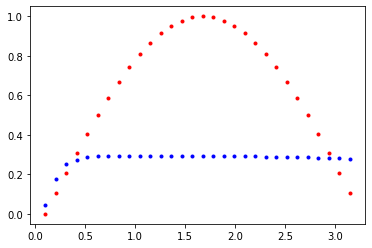

Loss:  0.037871021777391434


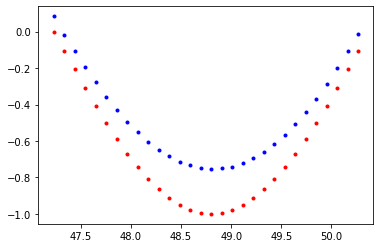

Loss:  0.012692938558757305


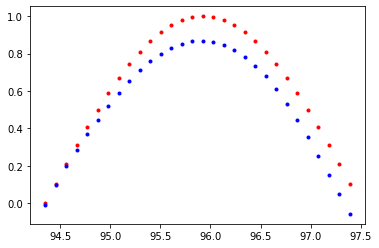

Loss:  0.0003094975254498422


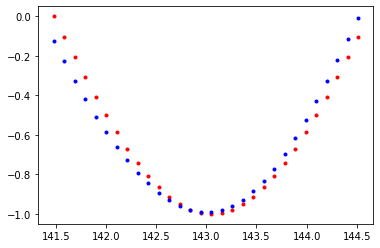

Loss:  0.0006034714751876891


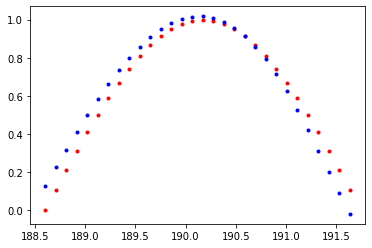

In [26]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)